In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_curve, plot_roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, plot_confusion_matrix

import dtreeviz.trees as dtreeviz

import graphviz
from matplotlib import pyplot as plt
import pandas as pd

from sklearn.model_selection import KFold, StratifiedKFold



In [2]:
def get_data():
    GSPREADHSEET_DOWNLOAD_URL = (
        "https://docs.google.com/spreadsheets/d/{gid}/export?format=csv&id={gid}".format
    )
    TP_GID = '1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0'
    df = pd.read_csv(GSPREADHSEET_DOWNLOAD_URL(gid=TP_GID))
    return df   

In [3]:
def feature_engineering(df):
    # Missings en barrio
    data_set_mejorado = df.copy()
    data_set_mejorado['barrio'] = data_set_mejorado['barrio'].apply(lambda x: 'Palermo' if str(x) == 'nan' else x)

    # Missings en categoría de trabajo
    data_set_mejorado['categoria_de_trabajo'] = data_set_mejorado['categoria_de_trabajo'].apply(lambda x: 'Sin categoria' if str(x) == 'nan' else x)

    # Missings en trabajo
    data_set_mejorado['trabajo'] = data_set_mejorado['trabajo'].apply(lambda x: 'No responde' if str(x) == 'nan' else x)

    # Eliminación de el atributo eduación alcanzada
    del data_set_mejorado['educacion_alcanzada']

    # Juntamos casado y casada en una misma categoría.
    data_set_mejorado['rol_familiar_registrado'] = data_set_mejorado['rol_familiar_registrado'].apply(lambda x : 'casado' if x == 'casada' else x)
    
    # One hot encoding provisorio
    data_set_mejorado = pd.get_dummies(data_set_mejorado, drop_first=True)
    
    return data_set_mejorado

In [4]:
df = feature_engineering(get_data())

In [72]:
params = { 'max_depth': range(3,8), 'criterion': ('gini','entropy'), 'splitter':('best', 'random'), 'max_features':('sqrt', 'log2') }
model = DecisionTreeClassifier()
X = df.drop('tiene_alto_valor_adquisitivo', 1).copy()
y = df['tiene_alto_valor_adquisitivo']

best_params = []
best_scores = []
for k in range(5, 15):
    gscv = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, cv=k)
    gscv.fit(X, y)
    best_scores.append(gscv.best_score_)
    print(k)

5
6
7
8
9
10
11
12
13
14


### Veamos si los folds parecen afectar a los scores

In [81]:
best_scores

[0.8414751618357783,
 0.841883492974315,
 0.8420140932584957,
 0.8437276172530708,
 0.8369497182130016,
 0.8406384075412987,
 0.8433459281817206,
 0.8400053456518193,
 0.8405058976916224,
 0.8394350271912467]

Parece que no. Por lo que podemos decir que el decision tree efectivamente predice con un Score que ronda el 0.84.

# El árbol

Para ello utilizaremos el que mejor predice para K = 15, pues es el valor de K más grande y por lo tanto sobreestima menos el score

In [93]:
X = df.drop('tiene_alto_valor_adquisitivo', 1).copy()
y = df['tiene_alto_valor_adquisitivo']

gscv = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, cv=15)
gscv.fit(X, y)

clf = DecisionTreeClassifier(criterion= gscv.best_params_['criterion'],
                       max_depth= gscv.best_params_['max_depth'],
                       max_features= gscv.best_params_['max_features'],
                       splitter=gscv.best_params_['splitter'])
clf.fit(X,y)
viz = dtreeviz.dtreeviz(
    clf,
    X,
    y,
    target_name='tiene_alto_valor_adquisitivo',
    feature_names=list(X.columns),
    class_names=list([0,1]),
    scale=1.5,
)

display(viz)

In [94]:
print(classification_report(y,gscv.predict(X)))

              precision    recall  f1-score   support

           0       0.88      0.94      0.90     24720
           1       0.74      0.58      0.65      7841

    accuracy                           0.85     32561
   macro avg       0.81      0.76      0.78     32561
weighted avg       0.84      0.85      0.84     32561



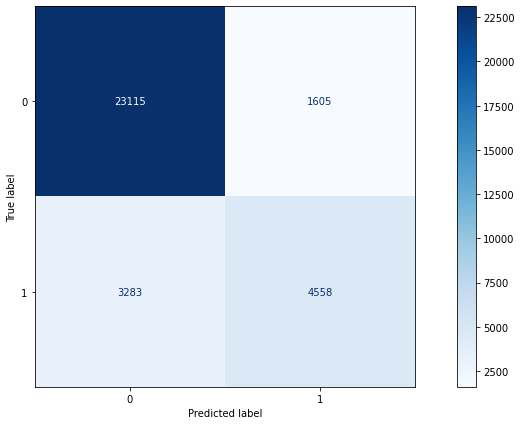

In [97]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(gscv, X, y, cmap=plt.cm.Blues,  ax=ax)
plt.show()

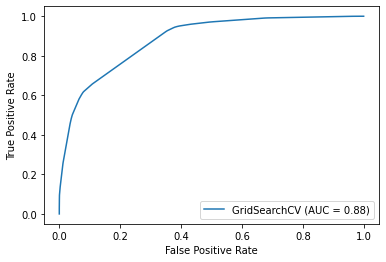

In [98]:
plot_roc_curve(gscv, X, y)